# Mask generating algorithm

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig, TrainingArguments, Trainer
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

accelerator = Accelerator()
device = accelerator.device

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [34]:
import torch 
from utils.img_utils import generate_mask
from utils import idx_to_selector
import torch.nn.functional as F
import numpy as np
from models import MLP
import math


def regret_loss_func(sim, mask_list, reverse_masked_prob_list):
    """ 
    reverse_prob_list: a list of prediction probabilities with masked part removed
    """
    bce_loss = nn.BCELoss(reduction='none')
    n_steps = len(mask_list)
    mask_prob = torch.sigmoid(sim).unsqueeze(1).expand(-1, n_steps, -1) # [N, n_steps, L]
    mask_samples = torch.stack(mask_list, dim=1) # [N, n_steps, L]
    mask_sample_probs = torch.stack(reverse_masked_prob_list, dim=1) # [N, n_steps, 1]
    # regret loss
    regret_loss = bce_loss(mask_prob, mask_samples) # [N, n_steps, L]
    regret_loss = (regret_loss * (1 - mask_sample_probs)).mean(1) # [N, L]
    regret_loss = regret_loss.mean() # [1]

    return regret_loss


class SimilarityMeasure(nn.Module):
    def __init__(self, embed_size):
        super(SimilarityMeasure, self).__init__()
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.logit_scale = nn.Parameter(torch.tensor(1.0))
    
    def forward(self, q, k):
        """
        Forward pass of the model.

        Args:
            q (torch.Tensor): Query tensor of shape [N, d].
            k (torch.Tensor): Key tensor of shape [N, L, d].

        Returns:
            torch.Tensor: Similarity tensor of shape [N, L].
        """
        Q = F.normalize(self.query(q), p=2, dim=-1)  # [N, d]
        K = F.normalize(self.key(k), p=2, dim=-1)  # [N, L, d]
        logit_scale = self.logit_scale.exp()

        similarity = torch.matmul(K, Q.unsqueeze(-1)).squeeze(1).squeeze(-1) * logit_scale  # [N, L]

        return similarity  # [N, L]


class MaskGeneratingModel(nn.Module):
    def __init__(self, pred_model, hidden_size, num_classes):
        super().__init__()

        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224', add_pooling_layer=False)
        self.pred_model = pred_model
        self.num_classes = num_classes

        self.similarity_measure = SimilarityMeasure(embed_size=hidden_size)

        self.bce_loss = nn.BCELoss(reduction='none')

        self.freeze_params()


    def freeze_params(self):
        """
        Freezes the parameters of the ViT and prediction model.

        This method sets the `requires_grad` attribute of all parameters in the ViT and prediction model to False,
        effectively freezing them and preventing them from being updated during training.

        Returns:
            int: Always returns 0.
        """
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.pred_model.parameters():
            param.requires_grad = False
        return 0


    def loss_func(self, sim, mask_list, masked_prob_list, reverse_masked_prob_list):
        """Calculate the loss for the given mask.

        Args:
            sim (Tensor): The similarity tensor of shape [N, L].
            mask (Tensor): The generated mask tensor of shape [N, L].
            probs (Tensor): The probability tensor of shape [N,]. Obtained by feeding the randomly generated mask to the prediction model.

        Returns:
            Tensor: The loss tensor of shape [N, L].
        """
        bce_loss = nn.BCELoss(reduction='none')
        n_steps = len(mask_list)
        L = sim.shape[-1]

        # generating probability
        mask_prob = torch.sigmoid(sim).unsqueeze(1).expand(-1, n_steps, -1) # [N, n_steps, L]
        # generated mask samples
        mask_samples = torch.stack(mask_list, dim=1) # [N, n_steps, L]

        # the prediction probability of the masked input
        mask_sample_probs = torch.stack(masked_prob_list, dim=1) # [N, n_steps, 1]
        # the prediction probability of the reverse masked input
        reverse_mask_sample_probs = torch.stack(reverse_masked_prob_list, dim=1) # [N, n_steps, 1]

        # selector, select which mask sample probability to use
        mask_selector = (mask_sample_probs > reverse_mask_sample_probs).float().expand(-1,-1, L) # [N, n_steps, L]

        
        # reward loss, if mask_sample_probs is higher, we want to optimize the probability of generating the masks
        reward_loss = bce_loss(mask_prob, mask_samples) # [N, n_steps, L]
        reward_loss = reward_loss * mask_sample_probs * mask_selector # [N, n_steps, L]
        # regret loss, if reverse_mask_sample_probs is higher, we want to optimize the probability of generating the reverse masks
        regret_loss = bce_loss(mask_prob, torch.ones_like(mask_prob)) # [N, n_steps, L]
        regret_loss = regret_loss * (1. - mask_selector) * (reverse_mask_sample_probs - mask_sample_probs) # [N, n_steps, L]
        # total_reward_loss = reward_loss.sum() / (mask_selector.sum() + 1e-5)  + regret_loss.sum() / ((1 - mask_selector).sum() + 1e-5) # [1]


        # mask_loss
        mask_prob = torch.sigmoid(sim)
        mask_loss = mask_prob.mean()


        loss =  reward_loss.mean() + 0.01 * mask_loss
        return {'loss': loss,
                'reward_loss': reward_loss.mean(),
                'regret_loss': regret_loss.mean(),
                'mask_loss': mask_loss}
    
    def forward(self, x, n_steps=10):
        interpretable_features = self.vit(x)[0][:, 1:, :] # [N, L, d]

        logits = self.pred_model(x).logits # [N, n_classes]
        predicted_class_idx = logits.argmax(-1) # [N, 1]
        predicted_class_selector = idx_to_selector(predicted_class_idx, self.num_classes) # [N, n_classes]
    

        original_feature = self.pred_model.vit(x)[0][:, 0, :] # [N, d]
        
        sim = self.similarity_measure(q=original_feature, k=interpretable_features) # [N, L]

        masked_probs_list = []
        reverse_masked_probs_list = []
        mask_list = []

        with torch.no_grad():
            for i in range(n_steps):
                mask = self.generate_mask(sim)
                mask_size = int(math.sqrt(mask.shape[-1]))
                reshaped_mask = mask.reshape(-1, mask_size, mask_size).unsqueeze(1) # [N, 1, size, size]
                H, W = x.shape[-2:]
                unsampled_mask = F.interpolate(reshaped_mask, size=(H, W), mode='nearest') # [N, 1, H, W]
                masked_input = x * unsampled_mask # [N, C, H, W]
                reverse_masked_input = x * (1 - unsampled_mask) # [N, C, H, W]

                masked_probs = torch.softmax(self.pred_model(masked_input).logits, dim=-1) # [N, n_classes]
                masked_probs = (masked_probs * predicted_class_selector).sum(-1, keepdim=True) # [N, 1]

                reverse_masked_probs = torch.softmax(self.pred_model(reverse_masked_input).logits, dim=-1) # [N, n_classes]
                reverse_masked_probs = (reverse_masked_probs * predicted_class_selector).sum(-1, keepdim=True) # [N, 1]

                masked_probs_list.append(masked_probs)
                reverse_masked_probs_list.append(reverse_masked_probs)
                
                mask_list.append(mask)
        
        loss = self.loss_func(sim, mask_list, masked_probs_list, reverse_masked_probs_list)
        return {
            'loss': loss,
            'sim': sim,
            'mask_list': mask_list,
            # 'masked_probs_list': masked_probs_list,
            # 'reversed_masked_probs_list': reverse_masked_probs_list,
        }

    
    def generate_mask(self, sim):
        """Generate a mask based on the similarity tensor. [generate action based on policy]

        Args:
            sim (Tensor): The similarity tensor of shape [N, L].

        Returns:
            Tensor: The generated mask tensor of shape [N, L].
        """
        mask_prob = torch.sigmoid(sim)

        # sample a mask (action) based on the mask probability (policy)
        mask = torch.bernoulli(mask_prob) # [N, L]
        
        return mask # [N, L]


    def attribute_img(self, 
                      x, 
                      image_size=224, 
                      patch_size=16, 
                      baseline=None, 
                      seed=None):
        """
        Generate attribution heatmap for an input image.

        Args:
            x: An image tensor of shape [N, C, H, W], where H = W = image_size.
            image_size: The size of the input image (H = W = image_size).
            patch_size: The size of each patch. Can be used to calculate the number of tokens in each patch 
                        (image_size // patch_size) ** 2.
            baseline: The baseline tensor. If None, the baseline is set to the zero tensor.
            n_samples: The number of random masks to be generated.
            mask_prob: The probability of a token being masked, i.e., replaced by the baseline.
            seed: The seed value for random number generation.

        Returns:
            Attribution heatmap.
        """

        size = image_size // patch_size
        N, C, H, W = x.shape
        with torch.no_grad():
            outputs = self.forward(x, n_steps=1)
            # mask_list = outputs['mask_list']
            # probs_list = outputs['probs_list']
            probs = torch.sigmoid(outputs['sim']).reshape(N, size, size)
           
            # mask = torch.stack(mask_list, dim=1) # [N, n_samples, L]
            # probs = torch.stack(probs_list, dim=1) # [N, n_samples, 1]
            # weighted_mask = (mask * probs).sum(1) # [N, L]
            # weighted_mask = weighted_mask.reshape(N, size, size)
        
        return probs
    
    def attribute_text(self, x, baseline=None, n_samples=1000,):
        # TODO
        raise NotImplementedError("This function hasn't been developed.")



# Load Model

In [35]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)
# set to eval mode
pred_model.eval()

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: golden retriever


# Load RandomMaskSaliency Model

In [36]:
mask_gen_model = MaskGeneratingModel(pred_model, hidden_size=config.hidden_size, num_classes=config.num_labels)
mask_gen_model.to(device)
print()

## Show Example

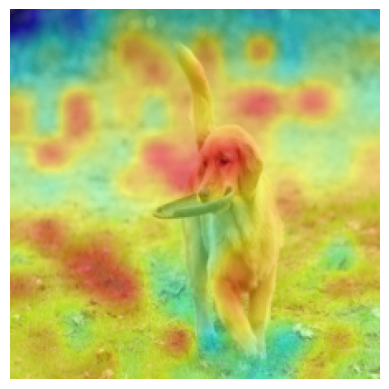

In [37]:
from utils.img_utils import unnormalize, unnormalize_and_255_scale, show_superimposed, get_overlap, plot_overlap, plot_overlap_np


img = inputs['pixel_values']
img = img.to(device)

heatmap = mask_gen_model.attribute_img(img, image_size=224, patch_size=16)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [38]:
heatmap.shape

(14, 14)

# Training

In [39]:
from torch.utils.data import DataLoader
def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_ds.set_transform(preprocess)


Repo card metadata block was not found. Setting CardData to empty.


In [40]:
batch_size = 512
num_workers = 16
train_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers)
n_steps = 20

params_to_optimize = [name for name, param in mask_gen_model.named_parameters() if param.requires_grad]
print("params to be optimized: ")
print(params_to_optimize)

params to be optimized: 
['similarity_measure.logit_scale', 'similarity_measure.query.weight', 'similarity_measure.query.bias', 'similarity_measure.key.weight', 'similarity_measure.key.bias']


In [41]:
from tqdm import tqdm

params_to_optimize = [param for param in mask_gen_model.parameters() if param.requires_grad]
optimizer = torch.optim.Adam(params_to_optimize, lr=1e-3, weight_decay=1e-4)
print()

for epoch in range(5):
    pbar = tqdm(train_dataloader)
    for idx, data in enumerate(pbar):
        pixel_values = data['pixel_values'].to(device)
        outputs = mask_gen_model(pixel_values, n_steps=n_steps)
        loss_dict = outputs['loss']
        loss = loss_dict['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch+1}, Step {idx+1}: Loss = {loss.item():.4f}, " 
                             f"Reward Loss = {loss_dict['reward_loss'].item():.4f}, "
                             f"Regret Loss = {loss_dict['regret_loss'].item():.4f}, "
                             f"Mask Loss = {loss_dict['mask_loss'].item():.4f}")

        if (idx) % 10 == 0:
            torch.save(mask_gen_model.state_dict(), f'mask_gen_model/mask_gen_model_{epoch}_{idx}.pth') 


torch.save(mask_gen_model.state_dict(), f'mask_gen_model/mask_gen_model_final_{epoch}_{idx}.pth') 


Epoch 1, Step 80: Loss = 0.0632, Reward Loss = 0.0617, Regret Loss = 1.7174, Mask Loss = 0.1480: 100%|██████████| 80/80 [1:07:04<00:00, 50.31s/it]
Epoch 2, Step 80: Loss = 0.0004, Reward Loss = 0.0000, Regret Loss = 2.4431, Mask Loss = 0.0432: 100%|██████████| 80/80 [1:06:51<00:00, 50.14s/it]
Epoch 3, Step 80: Loss = 0.0004, Reward Loss = 0.0000, Regret Loss = 2.8325, Mask Loss = 0.0353: 100%|██████████| 80/80 [1:06:38<00:00, 49.98s/it]
Epoch 4, Step 80: Loss = 0.0003, Reward Loss = 0.0000, Regret Loss = 2.9757, Mask Loss = 0.0295: 100%|██████████| 80/80 [1:06:40<00:00, 50.01s/it]
Epoch 5, Step 80: Loss = 0.0002, Reward Loss = 0.0000, Regret Loss = 3.1933, Mask Loss = 0.0231: 100%|██████████| 80/80 [1:06:35<00:00, 49.94s/it]


In [ ]:
# go with maximizing the probability differences.
Reward Loss = 0.1071, Regret Loss = 0.1133, Mask Loss = 0.4927:

# Demo trained examples

Predicted class: golden retriever


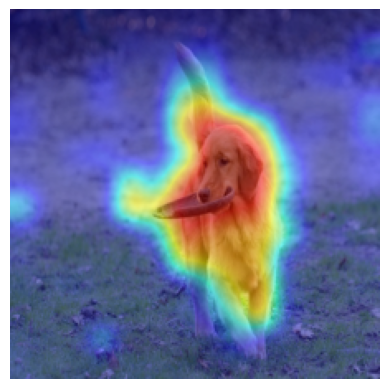

In [ ]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)
# set to eval mode
pred_model.eval()

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    print("Predicted class:", pred_model.config.id2label[predicted_class_idx])


img = inputs['pixel_values']
img = img.to(device)

heatmap = mask_gen_model.attribute_img(img, image_size=224, patch_size=16)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [ ]:
img = inputs['pixel_values']
img = img.to(device)

with torch.no_grad():
    output = mask_gen_model.forward(img, n_steps=2)

idx = 1
print(output['mask_list'][idx])
print(output['probs_list'][idx])
print(torch.sigmoid(output['sim']))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
         0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
         1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.]],
       device='cuda:0')
tensor([[0.0110]], device='cuda:0')
tensor([[0.2771, 0.2953, 0.3027, 0.2742, 0.3132, 0.2992

# Batch Evaluation

In [ ]:
from torch.utils.data import DataLoader
def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

_, _, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_ds.set_transform(preprocess)

# batch size is limited to 2, because n_steps could could huge memory consumption
batch_size = 1
test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
from evaluation import EvalGame
from tqdm import tqdm

# random_mask
root_path = 'results/mask-vit'
topk = 50

eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)

def save_heatmap(heatmap, batch_size, idx, root_path):
    # convert to numpy
    heatmap = heatmap.detach().cpu().numpy() # [N, 1, 14, 14]
    tail_index = batch_size * (idx + 1)
    file_name = os.path.join(root_path, f"heatmap-{tail_index}")
    np.save(file_name, heatmap)
    
    return 0
    

ins_score_list = []
del_score_list = []
heatmap_list = []


for idx, data in tqdm(enumerate(test_dataloader)):
    pixel_values = data['pixel_values'].to(device)
    with torch.no_grad():
        pseudo_label = model(pixel_values).argmax(-1).view(-1)

    # sum up all 3 RGB channels for heatmap
    attr = random_mask.attribute_img(pixel_values,
                                    image_size=config.image_size, 
                                    patch_size=config.patch_size, 
                                    n_samples=1000, 
                                    mask_prob=0.7) # [1,1,14,14]

    heatmap = attr.squeeze(1) # [1, 14, 14]
    heatmap_list.append(heatmap)
    if (idx + 1) * batch_size % 100 == 0:
        heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 14, 14)
        save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)
        heatmap_list = []

    # with torch.no_grad():
    #     input_img = pixel_values
    #     ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
    #     del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

    #     # append to list
    #     ins_score_list.append(ins_score)
    #     del_score_list.append(del_score)

if len(heatmap_list > 0):
    heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 224, 224)
    save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)

# ins_score = torch.cat(ins_score_list, dim=0)
# del_score = torch.cat(del_score_list, dim=0)

1539it [1:04:11,  2.50s/it]

In [ ]:
# from evaluation import EvalGame
# import os 
# import re
# from tqdm import tqdm


# root_path = 'results/mask-vit'
# model = lambda x: pred_model(pixel_values=x).logits
# eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)
# topk = 50

# def extract_number(filename):
#     """
#     Extract the first occurance of countinuous numbers in a file name
#     """
#     match = re.search(r'\d+', filename)
#     if match:
#         return int(match.group(0))
#     return 0

# def get_ordered_filename_list(root_path):
#     file_path_list = []
#     for filename in os.listdir(root_path):
#         if filename.endswith('.npy'):
#             file_path = os.path.join(root_path, filename)
#             file_path_list.append(file_path)
#     file_path_list = sorted(file_path_list, key=extract_number)
#     return file_path_list


# def load_heatmap(root_path):
#     file_path_list = get_ordered_filename_list(root_path)
#     for filename in file_path_list:
#        yield np.load(filename)


# ins_score_list = []
# del_score_list = []

# heatmap_generator = load_heatmap(root_path)
# test_dataloader_iterator = iter(test_dataloader)
# for idx, data in tqdm(enumerate(heatmap_generator)):
#     heatmap = torch.tensor(data, device=device)

#     with torch.no_grad():
#         # Average pooling to convert to 14*14 heatmap
#         heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
#         input_img = next(test_dataloader_iterator)['pixel_values'].to(device)
#         ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
#         del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

#         # append to list
#         ins_score_list.append(ins_score)
#         del_score_list.append(del_score)

7it [00:19,  2.72s/it]


KeyboardInterrupt: 

In [ ]:
ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)
print(ins_score.mean())
print(del_score.mean())

tensor(0.6008, device='cuda:0')
tensor(0.5319, device='cuda:0')


2500it [53:30,  1.28s/it]


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)

In [ ]:
ins_score.mean()

tensor(0.0598, device='cuda:0')

In [ ]:
del_score.mean()

tensor(0.8612, device='cuda:0')

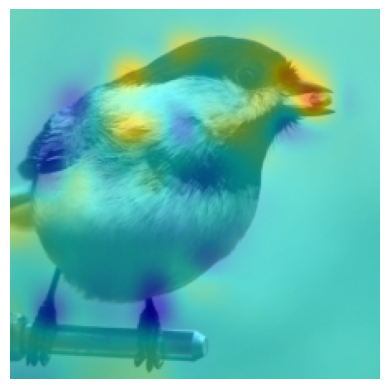

In [ ]:
heatmap_example = heatmap[1].detach().cpu().numpy()
img_example = pixel_values[1].detach().cpu().numpy().transpose(1,2,0)

_, _ = plot_overlap_np(img_example, heatmap_example, mean, std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


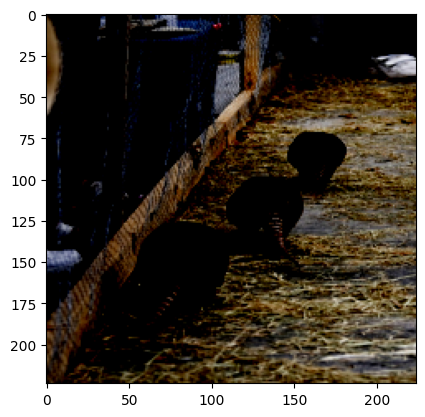